In [13]:
import gzip
import numpy as np
import tensorflow as tf
import cPickle as pickle
import matplotlib.pyplot as plt

### Utils

In [19]:
def plot_sample(data, true_y, pred_y, show_incorrect=True):
    """
    Show a random sample from the data set that was in/correctly labeled.
    """
    if show_incorrect:
        indexes = np.where(pred_y != test_y)[0]
    else:
        indexes = np.where(pred_y == test_y)[0]
    
    np.random.shuffle(indexes)
    chosen_idx = indexes[0]
    image = data[chosen_idx].reshape(28, 28)
    label = true_y[chosen_idx]
    predicted = pred_y[chosen_idx]
    
    plt.imshow(image, cmap='Greys')
    plt.title('Predicted %d / Expected %d' % (predicted, label))
    plt.show()
    
def generate_batches(data_x, data_y, batch_size):
    data_size = data_x.shape[0]
    indexes = np.arange(data_size)
    np.random.shuffle(indexes)
    
    for start_idx in xrange(0, data_size, batch_size):
        yield (data_x[start_idx:start_idx+batch_size], 
               data_y[start_idx:start_idx+batch_size])
    

### TF Code

In [15]:
with gzip.open('data/mnist.pkl.gz') as fd:
    # sets are tuples (images, labels)
    train_set, valid_set, test_set = pickle.load(fd)
    
# data dims
input_dim = 28*28 # dims of image
output_dim = 10 # output classes 0-9
    
# split and process data
train_x, train_y = train_set
train_y_ohe = np.eye(output_dim)[train_y] # one-hot encode

valid_x, valid_y = valid_set
valid_y_ohe = np.eye(output_dim)[valid_y] # one-hot encode

test_x, test_y = test_set
test_y_ohe = np.eye(output_dim)[test_y] # one-hot encode

In [17]:
# graph input
X = tf.placeholder(tf.float32, shape=[None, input_dim], name='X')
y = tf.placeholder(tf.float32, shape=[None, output_dim], name='y')

# model weights
W = tf.Variable(tf.zeros([input_dim, output_dim]), name='W')
b = tf.Variable(tf.zeros([output_dim]), name='b')

# model output
y_ = tf.nn.softmax(tf.matmul(X, W) + b, name='y_pred')

# minimize error
cost = tf.reduce_mean(-tf.reduce_sum(y * tf.log(y_)))

# optimizer
optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(cost)

# make predictions and measure quality
prediction = tf.arg_max(y_, 1)
correct_prediction = tf.equal(tf.arg_max(y, 1), prediction)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [33]:
# training params
max_epochs = 151
batch_size = 250

# run algorithm
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in xrange(max_epochs):
        # training in batches
        for batch_x, batch_y in generate_batches(train_x, train_y_ohe, batch_size):
            sess.run(optimizer, feed_dict={X: batch_x, y: batch_y})
            
        # compute eval metrics
        train_err = cost.eval(feed_dict={X: train_x, y: train_y_ohe})
        valid_err = cost.eval(feed_dict={X: valid_x, y: valid_y_ohe})
        valid_acc = accuracy.eval(feed_dict={X: valid_x, y: valid_y_ohe})
        
        if epoch % 10 == 0:
            print 'epoch %d -- valid acc: %.4f -- train err: %.2f - valid err: %.2f' % (epoch, valid_acc, train_err, valid_err)
            
    # compute metrics on test set
    test_pred = prediction.eval(feed_dict={X: test_x, y: test_y_ohe})
    test_err = cost.eval(feed_dict={X: test_x, y: test_y_ohe})
    test_acc = accuracy.eval(feed_dict={X: test_x, y: test_y_ohe})
    print 'final -- test acc %.4f - test err %.2f' % (test_acc, test_err)

epoch 0 -- valid acc: 0.7676 -- train err: 93267.82 - valid err: 18526.46
epoch 10 -- valid acc: 0.8611 -- train err: 38986.29 - valid err: 7322.32
epoch 20 -- valid acc: 0.8788 -- train err: 30456.96 - valid err: 5607.52
epoch 30 -- valid acc: 0.8849 -- train err: 26803.23 - valid err: 4895.42
epoch 40 -- valid acc: 0.8900 -- train err: 24692.45 - valid err: 4494.37
epoch 50 -- valid acc: 0.8943 -- train err: 23284.14 - valid err: 4232.45
epoch 60 -- valid acc: 0.8984 -- train err: 22261.20 - valid err: 4045.65
epoch 70 -- valid acc: 0.9009 -- train err: 21475.37 - valid err: 3904.41
epoch 80 -- valid acc: 0.9026 -- train err: 20847.29 - valid err: 3793.07
epoch 90 -- valid acc: 0.9046 -- train err: 20330.27 - valid err: 3702.52
epoch 100 -- valid acc: 0.9051 -- train err: 19894.87 - valid err: 3627.09
epoch 110 -- valid acc: 0.9058 -- train err: 19521.50 - valid err: 3563.02
epoch 120 -- valid acc: 0.9066 -- train err: 19196.59 - valid err: 3507.74
epoch 130 -- valid acc: 0.9076 -- t

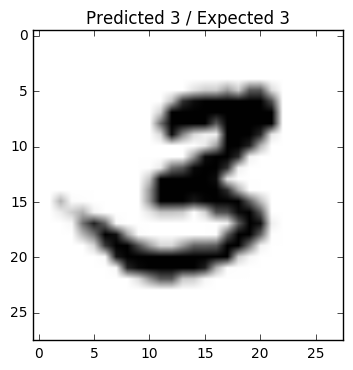

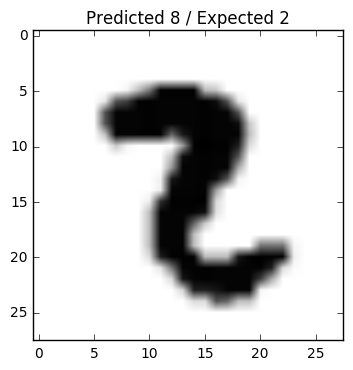

In [35]:
plot_sample(test_x, test_y, test_pred, False)
plot_sample(test_x, test_y, test_pred, True)